<h1  style="color:white; background-color: #154360; padding:30px;"> 
Résultats numériques de l'algorithme Longstaff-Schwartz  </h1>

Dans ce notebook, je présente les résultats de mon algorithme Longstaff-Schwarz. Je 
prends  pour benchmark les valeurs [Deep Optimal Stopping](http://arxiv.org/abs/1804.05394)
et [LongStaff & Schwartz](https://www.researchgate.net/profile/Eduardo-Schwartz-2/publication/5216848_Valuing_American_Options_by_Simulation_A_Simple_Least-Squares_Approach/links/616d874fb90c51266264874a/Valuing-American-Options-by-Simulation-A-Simple-Least-Squares-Approach.pdf?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6InB1YmxpY2F0aW9uIn19).


In [2]:
import sys
import helper_plots


sys.path.append("..")


import numpy as np

import src.tools.diffusion.black_scholes as bs

import src.tools.basis_function.basis_function as basis_function

import src.tools.basis_function.monomials as monomials

import src.tools.basis_function.laguerre as laguerre

import src.tools.option.option_main_class as option_main_class

from typing import List
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import src.main.dynamic_programming.least_squares_ls_pricer as least_square_ls_pricer

## Cas d'une option bermudéenne avec payoff européen 

On considère une option bermudénne classique avec un seul sous-jacent et dont le payoff
est $f(x) = (K -x)_{+}$ pour un put. On ne s'intéresse pas au cas du call car quand le 
pas de discrétization tend vers 0 le prix du call tend vers le prix d'une option 
américaine qui vaut le prix d'un call européen (quand les taux sont positifs).

In [12]:
benchmark = 4.478
asset = bs.BlackScholes(40, 0.06, 0.4)
fun = monomials.Monomials(10)
strike = 40
r = 0.06
maturity = 1
n = 50
tirage = 20
payoff = lambda x: np.maximum(strike - np.squeeze(x), 0)
o = option_main_class.Option(maturity, strike, 0.06, payoff)
pricer_lstq = least_square_ls_pricer.PricerLeastSquaresLongstaffSchwarz(
    o, [asset], fun
)

In [13]:
N = 100000
price, ci, cd, _, _ = pricer_lstq.price(n,N)
print(f"price is {price,ci,cd}")

price is (5.1823571443949845, 5.215131123370231, 5.149583165419738)


In [21]:
df_losses = pd.DataFrame(pricer_lstq.intermediate_values)
df_losses["step"] = df_losses["step"].iloc[::-1].reset_index(drop=True)
df_losses["loss"].describe()

count    48.000000
mean      3.313332
std       1.875422
min       0.657524
25%       1.829358
50%       2.865562
75%       4.574718
max       7.912565
Name: loss, dtype: float64

Text(0.5, 1.0, 'MSE loss per time step')

<Figure size 800x700 with 0 Axes>

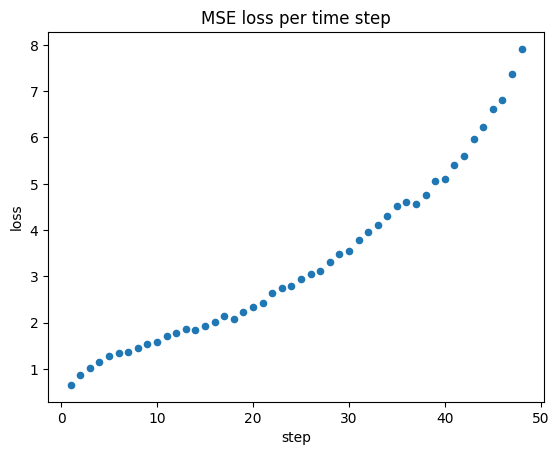

In [23]:
plt.figure(figsize=(8,7))
df_losses.plot(x='step',y="loss",kind="scatter")
plt.title("MSE loss per time step")

In [5]:
list_number_simulations = [N for N in range(10, 100000, 10000)]
list_put_price = np.zeros((tirage,10))
list_time = np.zeros((tirage,10))
list_CI_down = []
List_CI_up = []

for idx, n_simulation in tqdm(enumerate(range(10,100000,10000))):
    ci_down_tmp = 0
    ci_up_tmp = 0
    for m in range(tirage):
        price, CI_up, CI_down, t , _ = pricer_lstq.price(n,n_simulation)
        list_put_price[m,idx] = price
        list_time[m,idx] = t
        ci_down_tmp += CI_down
        ci_up_tmp += CI_up
    list_CI_down.append(ci_down_tmp/tirage)
    List_CI_up.append(ci_up_tmp/tirage)


10it [05:06, 30.65s/it]


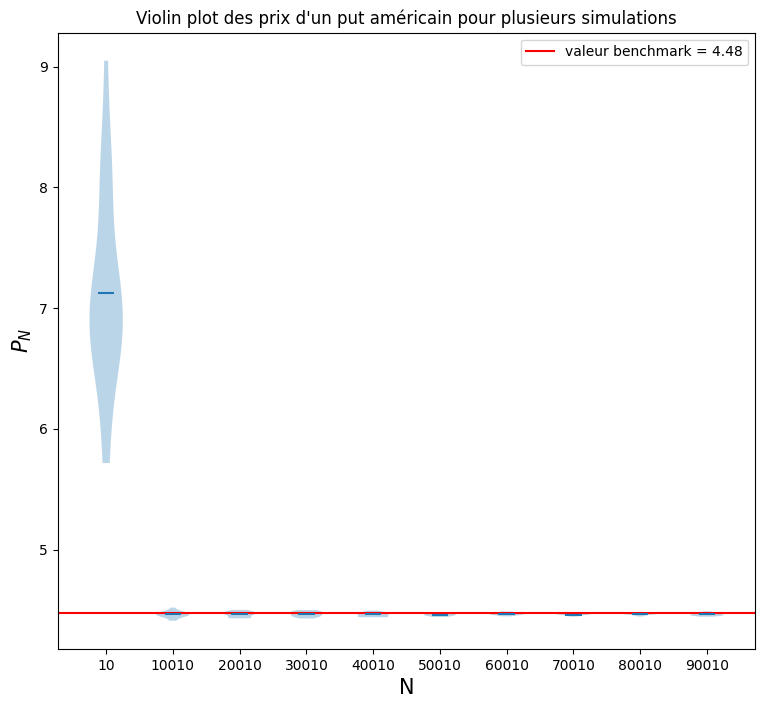

In [6]:
helper_plots.violin_plot(
    list_put_price,
    list_number_simulations,
    benchmark,
    "Violin plot des prix d'un put américain pour plusieurs simulations"
)

In [7]:
list_error = [
    np.mean(list_put_price[:, idx]) - benchmark
    for idx in range(list_put_price.shape[1])
]

list_time = [np.mean(list_time[:, idx]) for idx in range(list_time.shape[1])]


df = pd.DataFrame(

    {

        "number of simulation": list_number_simulations,
        "time": list_time,
        "error": list_error,

        "CI_down": list_CI_down,

        "CI_up": List_CI_up,

    }

)

In [8]:
df.head(n=10)

,number of simulation,time,error,CI_down,CI_up
0,10,0.005698,2.331665,4.707979,8.911351
1,10010,0.311743,-0.009895,4.411711,4.524499
2,20010,0.672568,-0.019568,4.419151,4.497713
3,30010,1.016224,-0.008059,4.437644,4.502239
4,40010,1.572853,-0.016485,4.433657,4.489373
5,50010,2.655518,-0.017479,4.435546,4.485495
6,60010,3.115982,-0.014075,4.441085,4.486764
7,70010,3.556685,-0.016296,4.440560,4.482849
8,80010,5.018668,-0.011388,4.446799,4.486426
9,90010,5.712693,-0.014715,4.444634,4.481936


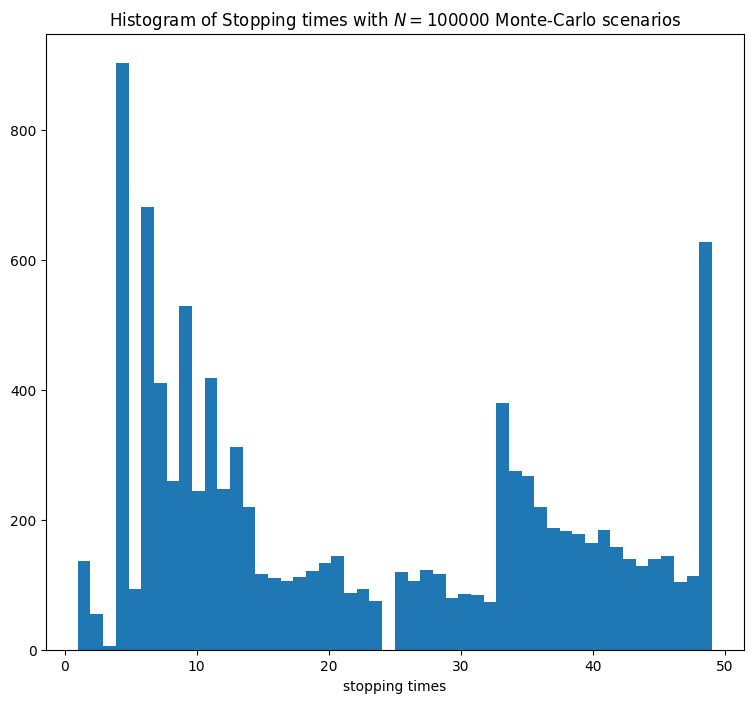

In [9]:
_, _, _, _ , final_stopping_times = pricer_lstq.price(n,10000,seed=2024)
plt.figure(figsize=(9, 8))
plt.hist(final_stopping_times,bins=50,histtype='barstacked')
plt.xlabel("stopping times")
plt.title("Histogram of Stopping times with $N=100000$ Monte-Carlo scenarios")
plt.show()

## Impact du degrée du polynôme

On fixe $S_0 = 36$, $K = 40$, $r = 0.015$, $\sigma = 0.2$, et on teste 
plusieurs degrées de polynôme pour la régression, sur plusieurs simulations avec la même
graine pour la génération de nombres aléatoires.

In [3]:
benchmark = 4.478
asset = bs.BlackScholes(36, 0.06, 0.2)
strike = 40
r = 0.06
maturity = 1
n = 100
payoff = lambda x: np.maximum(strike - x, 0)
o = option_main_class.Option(maturity, strike, r, payoff)
prices = np.zeros((9, 10))
times = np.zeros((9, 10))
list_simulation = [i for i in range(1000, 100000, 10000)]

for idx, degree in tqdm(enumerate(range(2, 20, 2))):
    fun = monomials.Monomials(degree)
    pricer_lstq_tmp = least_square_ls_pricer.PricerLeastSquaresLongstaffSchwarz(
        o, [asset], fun
    )
    for i, n_simulation in enumerate(list_simulation):
        price, _, _, t, _ = pricer_lstq_tmp.price(n, n_simulation, seed=2024)
        prices[idx, i] = price
        times[idx, i] = t

0it [00:00, ?it/s]

5it [02:35, 31.15s/it]


KeyboardInterrupt: 

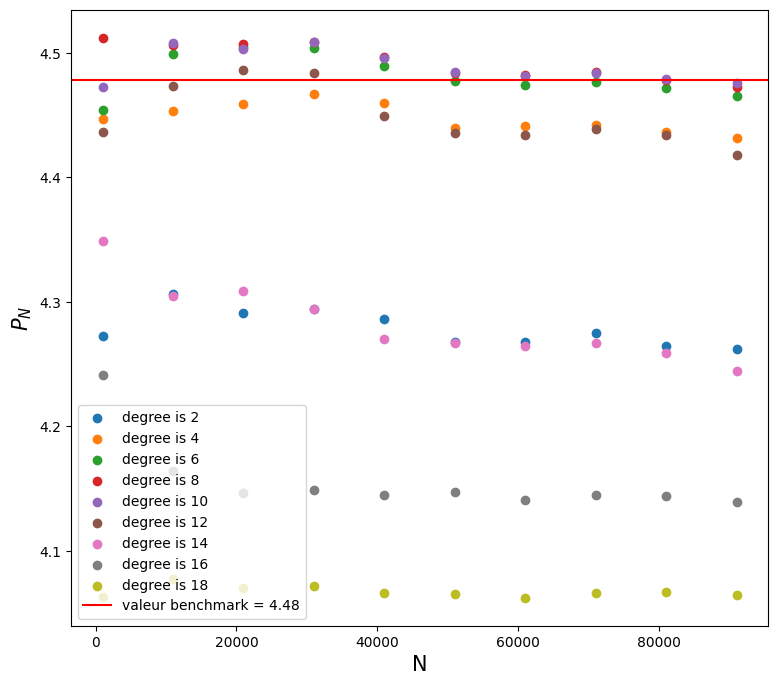

In [15]:
plt.figure(figsize=(9, 8))


for idx,degree in enumerate(range(2,20,2)):
    plt.scatter(list_simulation, prices[idx, :],label=f"degree is {degree}")
valeur_theo = "valeur benchmark = {:.2f}".format(benchmark)  # contenu de legend
plt.axhline(y=benchmark, color="red", label=str(valeur_theo))  # ligne horizontale

plt.xlabel("N", fontsize=15)
plt.ylabel("${P}_{N}$", fontsize=15)

plt.legend()
plt.show()

In [4]:
def plot_fit(list_fun: List[basis_function.BasisFunction], t: int):
    """plot fitted values of basis function 

    Parameters
    ----------
    list_fun : List[basis_function.BasisFunction]
        list a basis functions.
    t : int
        timestep of the fit.
    """
    n, N = 10, 100
    list_pricer = []
    for fun in list_fun:
        pricer_lstq = least_square_ls_pricer.PricerLeastSquaresLongstaffSchwarz(
            o, [asset], fun
        )
        _, _, _, _, _ = pricer_lstq.price(n=10, N=100, seed=2024)
        list_pricer.append(pricer_lstq)

    x = list_pricer[0].models["underlying"][t]
    y = list_pricer[0].models["cash_flows"][t]
    sorted_indices = np.argsort(x)
    x = np.array(x)[sorted_indices]
    y = np.array(y)[sorted_indices]

    fitted = []
    for pricer in list_pricer:
        coeff = pricer.models["coefficients"][t]
        fitted_tmp = [
            pricer.basis_function.get_polynom(np.array([x_]), coeff) for x_ in x
        ]
        fitted_tmp = np.array(fitted_tmp)
        fitted.append(fitted_tmp)

    # Plotting the sorted data
    plt.figure(figsize=(9, 8))
    plt.scatter(x, y, label="Actual Values")
    for idx, fit in enumerate(fitted):
        if isinstance(list_fun[idx], monomials.Monomials):
            plt.plot(x, fit, label=f"Monomials with degree {list_fun[idx].degree}")
        elif isinstance(list_fun[idx], laguerre.Laguerre):
            plt.plot(
                x, fit, label=f"Laguerre Polynomial with degree {list_fun[idx].degree}"
            )
    plt.xlabel(r"$S_{t_{n-1}}$", fontsize=15)
    plt.ylabel(r"$f(X_{\tau_n})$", fontsize=15)
    plt.title(f"Fitted values for n = {n - t}, total steps = {n}")
    plt.legend()
    plt.show()

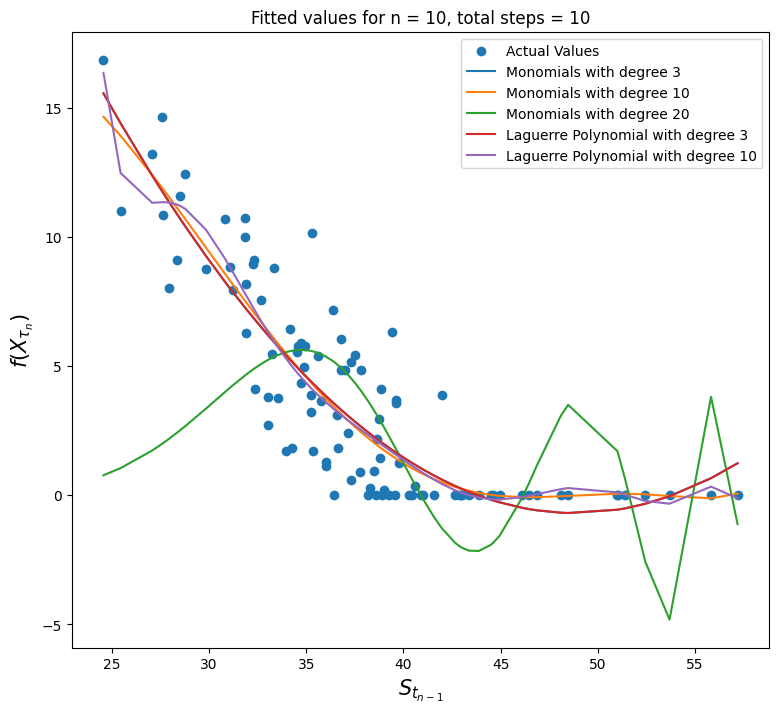

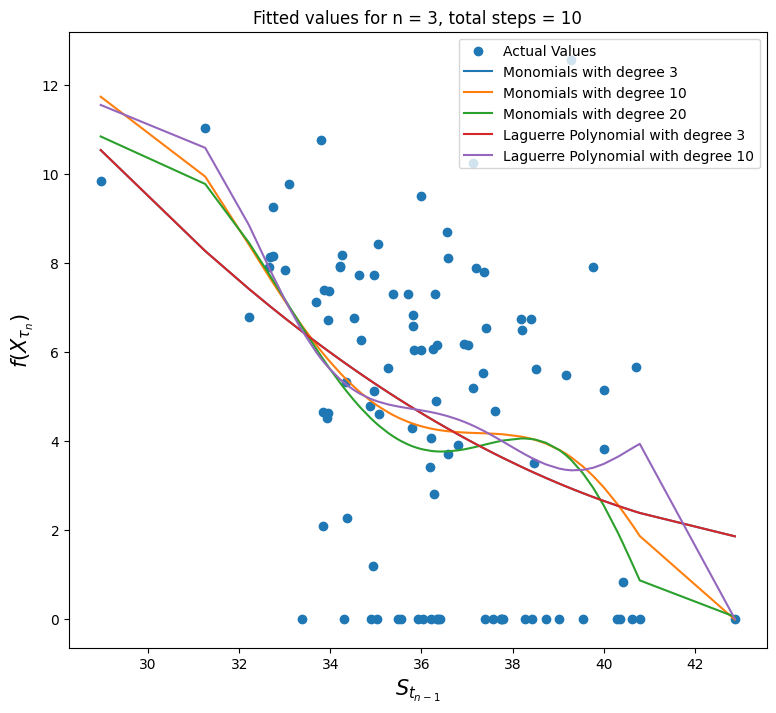

In [9]:
list_fun = [
    monomials.Monomials(5),
    monomials.Monomials(10),
    monomials.Monomials(20),
    laguerre.Laguerre(5),
    laguerre.Laguerre(10),
]
plot_fit(list_fun, 0)
plot_fit(list_fun, 7)

### Impact du polynôme

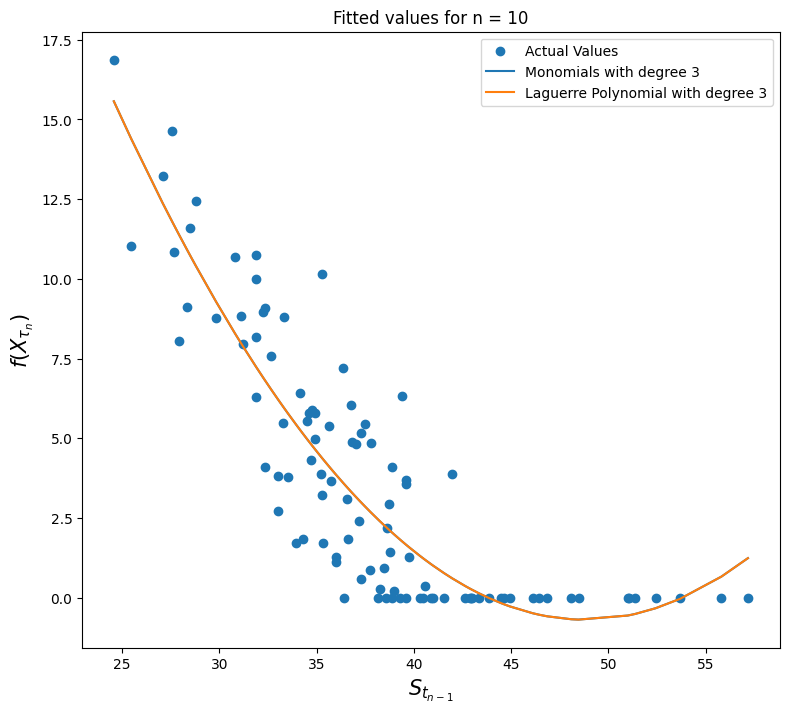

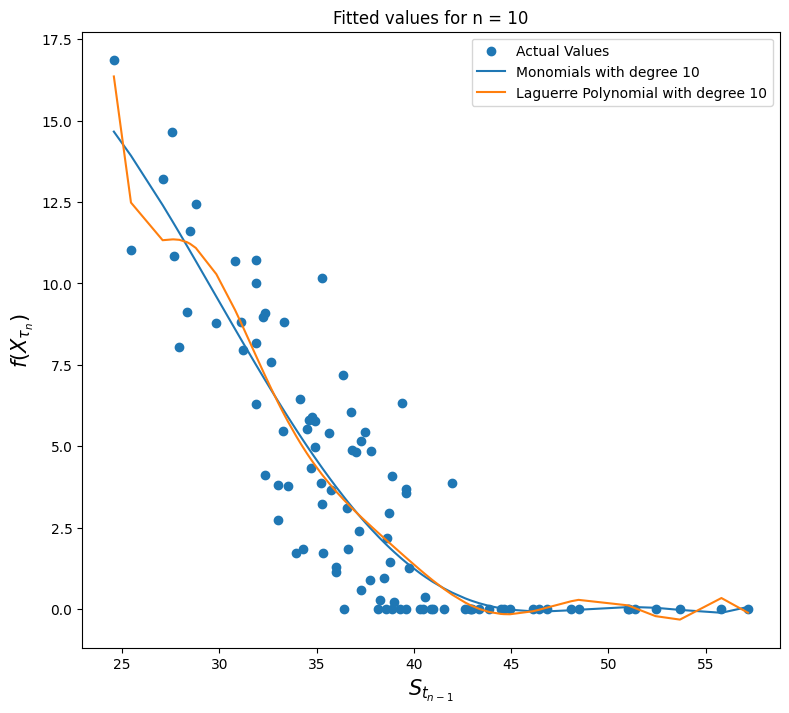

In [46]:
list_fun1 = [monomials.Monomials(3), laguerre.Laguerre(3)]
list_fun2 = [monomials.Monomials(10), laguerre.Laguerre(10)]
plot_fit(list_fun1,0)
plot_fit(list_fun2,0)

## Cas d'une option bermudéenne maxcall

### d=2 et 20

On considère une option bermudénne maxcall avec au moins deux sous-jacents et dont le payoff
est $f(x) = (\max_{i \in \{1,d \} } x_i - K) _{+}$ avec $x \in \mathbb{R^d}$ pour un maxcall. 

In [7]:
def call_payoff(x):
    d = x.shape[1]
    max_mat = np.zeros((x.shape[0], d))
    for i in range(d):
        max_mat[:, i] = np.maximum(x[:, i] - strike, 0)
    return np.max(max_mat, axis=1)

In [18]:
d = 50
asset = [bs.BlackScholes(100, 0.05, 0.2,dividend=0.1) for i in range(d)]
fun = monomials.Monomials(10)
strike = 100
r = 0.05
maturity = 3
n = 10
tirage = 20
o = option_main_class.Option(maturity, strike, 0.05, call_payoff)
pricer_lstq = least_square_ls_pricer.PricerLeastSquaresLongstaffSchwarz(
    o, asset, fun
)

In [19]:
N = 100000
price, ci, cd, _, _ = pricer_lstq.price(n,N,disable=False)
print(f"price is {price,ci,cd}")

100%|██████████| 8/8 [04:31<00:00, 33.94s/it]

price is (68.96311116526283, 69.09492235045285, 68.83129998007281)


In [34]:
tirage = 20
n = 10
strike = 100


o = option_main_class.Option(3, 100, 0.05, call_payoff)
fun = monomials.Monomials(5)
asset1 = [bs.BlackScholes(110, 0.05, 0.2, 0.10) for _ in range(2)]
asset2 = [bs.BlackScholes(110, 0.05, 0.2, 0.10) for _ in range(20)]
pricer1 = least_square_ls_pricer.PricerLeastSquaresLongstaffSchwarz(o,asset1,fun)
pricer2 = least_square_ls_pricer.PricerLeastSquaresLongstaffSchwarz(o,asset2,fun)

list_number_simulations = [N for N in range(10, 100000, 20000)]
list_max_call_price1 = np.zeros((tirage, 5))
list_max_call_price2 = np.zeros((tirage, 5))
list_time = np.zeros((tirage, 5))
list_CI_down = []
List_CI_up = []

for idx, n_simulation in tqdm(enumerate(range(10, 100000, 20000))):
    ci_down_tmp = 0
    ci_up_tmp = 0
    for m in range(tirage):
        price1, CI_up, CI_down, t, _ = pricer1.price(n,n_simulation)
        price2, _, _, _, _ = pricer2.price(n,n_simulation)
        list_max_call_price1[m, idx] = price1
        list_max_call_price2[m,idx] = price2
        list_time[m, idx] = t
        ci_down_tmp += CI_down
        ci_up_tmp += CI_up
    list_CI_down.append(ci_down_tmp / tirage)
    List_CI_up.append(ci_up_tmp / tirage)

5it [17:55, 215.04s/it]


In [39]:
list_number_simulations = [N for N in range(10, 100000, 20000)]

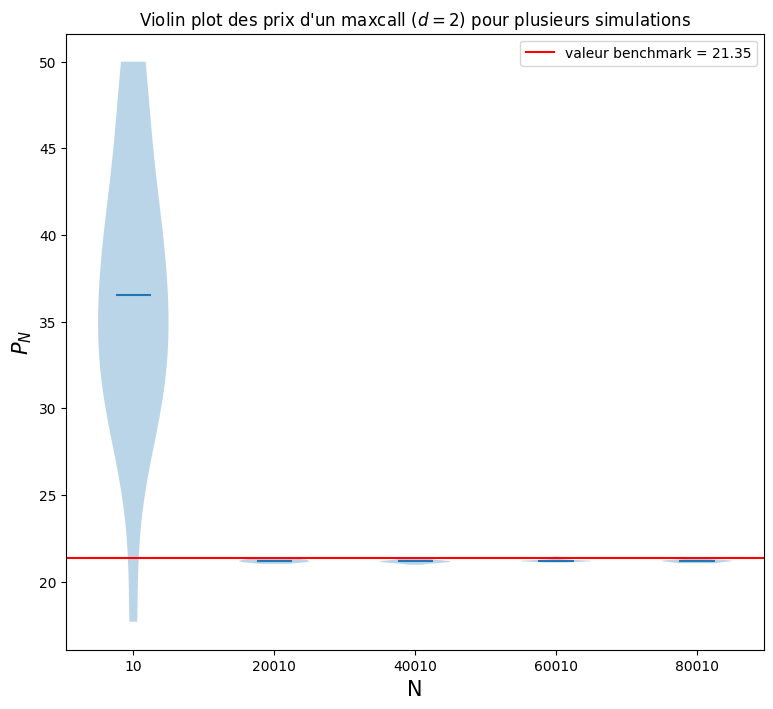

In [40]:
benchmark = 21.349
helper_plots.violin_plot(
    list_max_call_price1,
    list_number_simulations,
    benchmark,
    "Violin plot des prix d'un maxcall ($d=2$) pour plusieurs simulations",
)

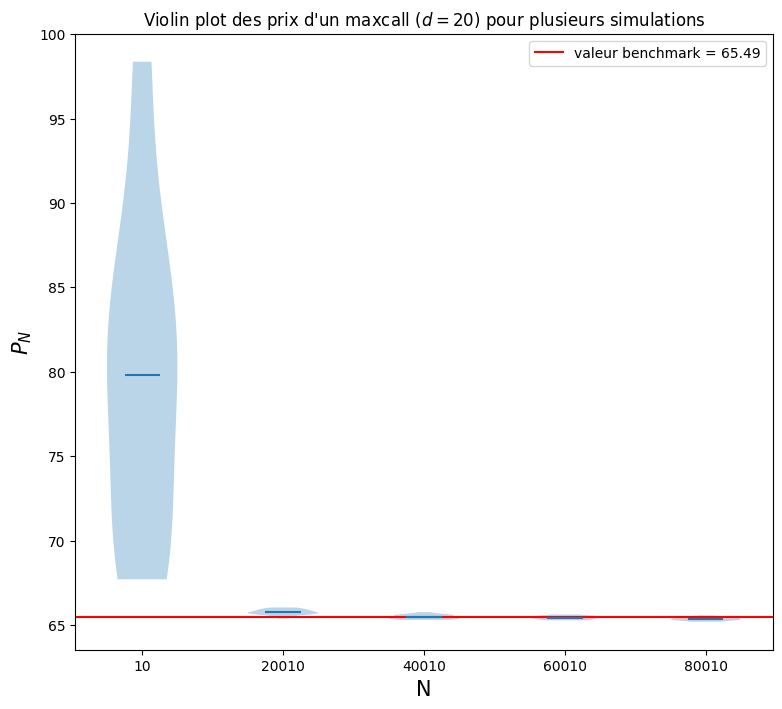

In [41]:
benchmark = 65.494
helper_plots.violin_plot(
    list_max_call_price2,
    list_number_simulations,
    benchmark,
    "Violin plot des prix d'un maxcall ($d=20$) pour plusieurs simulations",
)

In [12]:
List_time = []
n_simulation = 10000
n = 10
fun = monomials.Monomials(5)
o = option_main_class.Option(3, 100, 0.05, call_payoff)
strike = 100

for d in tqdm(range(2, 50)):
    asset = [bs.BlackScholes(110, 0.05, 0.2, 0.10) for _ in range(d)]
    pricer = least_square_ls_pricer.PricerLeastSquaresLongstaffSchwarz(
        o, asset, fun
    )
    _, _, _, t, _ = pricer.price(n, n_simulation,seed=2024)
    List_time.append(t)

100%|██████████| 48/48 [04:33<00:00,  5.69s/it]


C:\Users\amaury.manzione\AppData\Local\Temp\ipykernel_15844\3291045282.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


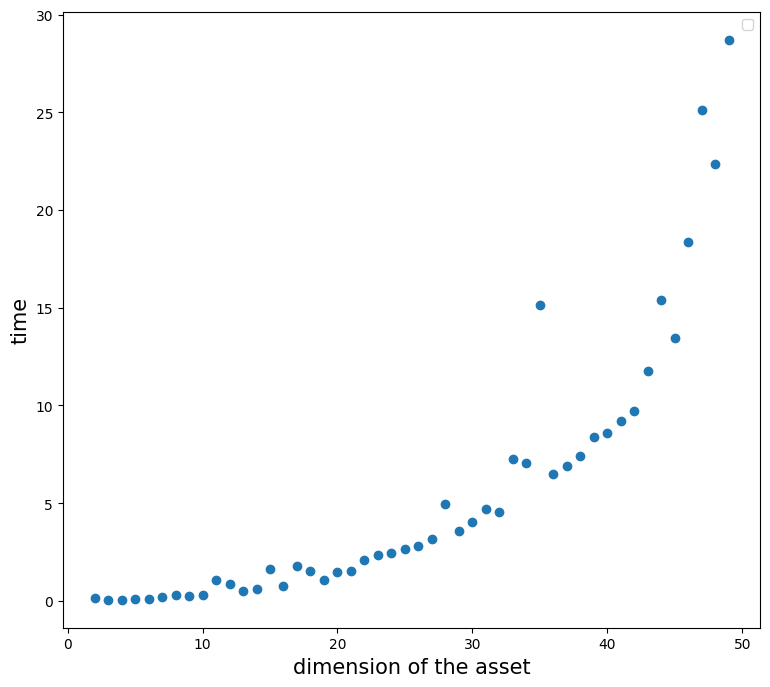

In [13]:
plt.figure(figsize=(9,8))


dimension = [i for i in range(2,50)]

plt.scatter(dimension,List_time)

plt.xlabel("dimension of the asset",fontsize=15)
plt.ylabel("time",fontsize=15)

plt.legend()
plt.show()